In [ ]:
import numpy as np
import math
import sys
import progressbar
import matplotlib.pyplot as plt

In [ ]:
def to_categorical(x, n_col=None):
    """ One-hot encoding номинального признака """
    if not n_col:
        n_col = np.amax(x) + 1
    one_hot = np.zeros((x.shape[0], n_col))
    one_hot[np.arange(x.shape[0]), x] = 1
    return one_hot

def divide_on_feature(X, feature_i, threshold):
    """ Разделение набора данных по превышению признака feature_i порога"""
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return [X_1, X_2]

def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


def standardize(X):
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std


def shuffle_data(X, y, seed=None):
    """ случайное перемешивание X и y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Разделение набора данных на обучающий и тестовый """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test

def to_nominal(x):
    """ Перевод из one-hot encoding в номинальные значения """
    return np.argmax(x, axis=1)

def calculate_entropy(y):
    """ энтропия """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy

def calculate_variance(X):
    """ дисперсия X """
    mean = np.ones(np.shape(X)) * X.mean(0)
    n_samples = np.shape(X)[0]
    variance = (1 / n_samples) * np.diag((X - mean).T.dot(X - mean))

    return variance


def mean_squared_error(y_true, y_pred):
    """ средняя квадратичная ошибка (y_true, y_pred) """
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse

def accuracy_score(y_true, y_pred):
    """ Доля правильных ответов """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

class Loss(object):
    def loss(self, y_true, y_pred):
        return NotImplementedError()

    def gradient(self, y, y_pred):
        raise NotImplementedError()

    def acc(self, y, y_pred):
        return 0

class SquareLoss(Loss):
    def __init__(self): pass

    def loss(self, y, y_pred):
        return 0.5 * np.power((y - y_pred), 2)

    def gradient(self, y, y_pred):
        return -(y - y_pred)

class CrossEntropy(Loss):
    def __init__(self): pass

    def loss(self, y, p):
        # Избегаем деления на 0
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        # Избегаем деления на 0
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - (y / p) + (1 - y) / (1 - p)

bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

In [ ]:
class DecisionNode():
    """Узел или лист дерева

    Параметры:
    -----------
    feature_i: int
        Номер признака, используемого для ветвления.
    threshold: float
        Пороговое значение, с которым мы будем сравнивать значения признака feature_i при определении прогноза.
    value: float
        Предсказанный класс для задачи классификации или предсказанное значение числового признака y для задачи регрессии.
    true_branch: DecisionNode
        Следующий узел в случае превышения порога.
    false_branch: DecisionNode
        Следующий узел в случае недостижения порога.
    """
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i          # Index for the feature that is tested
        self.threshold = threshold          # Threshold value for feature
        self.value = value                  # Value if the node is a leaf in the tree
        self.true_branch = true_branch      # 'Left' subtree
        self.false_branch = false_branch    # 'Right' subtree


# Super class of RegressionTree and ClassificationTree
class DecisionTree(object):
    """Родительский класс для RegressionTree и ClassificationTree.

    Параметры:
    -----------
    min_samples_split: int
        Минимальное количество объектов, необходимое для разбиения при построении дерева.
    min_impurity: float
        Минимальная информативность, необходимая для дальнейшего ветвления при построении дерева.
    max_depth: int
        Максимальная глубина дерева.
    loss: function
        Функция потреь, используемая в градиентном бустинге для вычисления информативности.
    """
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  # Root node in dec. tree
        # Minimum n of samples to justify split
        self.min_samples_split = min_samples_split
        # The minimum impurity to justify split
        self.min_impurity = min_impurity
        # The maximum depth to grow the tree to
        self.max_depth = max_depth
        # Function to calculate impurity (classif.=>info gain, regr=>variance reduct.)
        self._impurity_calculation = None
        # Function to determine prediction of y at leaf
        self._leaf_value_calculation = None
        # If y is one-hot encoded (multi-dim) or not (one-dim)
        self.one_dim = None
        # If Gradient Boost
        self.loss = loss

    def fit(self, X, y, loss=None):
        """ Построение дерева """
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None

    def _build_tree(self, X, y, current_depth=0):
        """ Рекурсивный метод, который строит дерево решений и разбивает X и соответствующий y
        по признаку, который (на основе информативности) наилучшим образом разделяет данные"""

        largest_impurity = 0
        best_criteria = None    # номер факторного признака и порог
        best_sets = None        # Подмножества данных

        #
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        #
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # Вычисляем информативность для каждого факторного признака
            for feature_i in range(n_features):
                # ВСЕ значения признака feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                # Цикл по всем уникальным значениям feature_i с вычислением информативности
                for threshold in unique_values:
                    # Разделение X и y по критерию X[feature_i] >= threshold
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Значения y-в двух подмножествах
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # Вычисление информативности
                        impurity = self._impurity_calculation(y, y1, y2)

                        # Если порог привел к повышению информационного выигрыша,
                        # созраним порогт и номар признака
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],   # X левого поддерева
                                "lefty": Xy1[:, n_features:],   # y левого поддерева
                                "rightX": Xy2[:, :n_features],  # X правого поддерева
                                "righty": Xy2[:, n_features:]   # y правого поддерева
                                }

        if largest_impurity > self.min_impurity:
            # Строим поддеревья
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                                "threshold"], true_branch=true_branch, false_branch=false_branch)

        # Определение значения в листе
        leaf_value = self._leaf_value_calculation(y)

        return DecisionNode(value=leaf_value)


    def predict_value(self, x, tree=None):
        """ Рекурсивный поиск вниз по дереву с построением прогноза по значению итогового листа"""

        if tree is None:
            tree = self.root

        # Если мы находимся в листе, т.е. есть значение value, возвращаем его как прогноз
        if tree.value is not None:
            return tree.value

        # Выбор факторного признака
        feature_value = x[tree.feature_i]

        # Выбор левого или правого поддерева в зависимости от превышения порога
        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        # Прогноз на поддереве
        return self.predict_value(x, branch)

    def predict(self, X):
        """ Поэлементная классификация набора данных с возвращением множества прогнозов y"""
        y_pred = [self.predict_value(sample) for sample in X]
        return y_pred

    def print_tree(self, tree=None, indent=" "):
        """ Рекурсивный вывод дерева """
        if not tree:
            tree = self.root

        # Если это лист, выводим значение
        if tree.value is not None:
            print (tree.value)
        # иначе идем вглубь
        else:
            # номер признака и порог
            print ("%s:%s? " % (tree.feature_i, tree.threshold))
            # Сценарий при достижении порога
            print ("%sT->" % (indent), end="")
            self.print_tree(tree.true_branch, indent + indent)
            # Сценарий при недостижении порога
            print ("%sF->" % (indent), end="")
            self.print_tree(tree.false_branch, indent + indent)



class XGBoostRegressionTree(DecisionTree):
    """
    Дерево регрессии для XGBoost
    - Источник -
    http://xgboost.readthedocs.io/en/latest/model.html
    """

    def _split(self, y):
        """ Разделение y на истинные значения и прогнозы (в левой половине y истинные значения, в правой - прогнозы). """
        col = int(np.shape(y)[1]/2)
        y, y_pred = y[:, :col], y[:, col:]
        return y, y_pred

    def _gain(self, y, y_pred):
        nominator = np.power((y * self.loss.gradient(y, y_pred)).sum(), 2)
        denominator = self.loss.hess(y, y_pred).sum()
        return 0.5 * (nominator / denominator)

    def _gain_by_taylor(self, y, y1, y2):
        # Разделение
        y, y_pred = self._split(y)
        y1, y1_pred = self._split(y1)
        y2, y2_pred = self._split(y2)

        true_gain = self._gain(y1, y1_pred)
        false_gain = self._gain(y2, y2_pred)
        gain = self._gain(y, y_pred)
        return true_gain + false_gain - gain

    def _approximate_update(self, y):
        # разделение y на y, y_pred
        y, y_pred = self._split(y)
        # Метод Ньютона
        gradient = np.sum(y * self.loss.gradient(y, y_pred), axis=0)
        hessian = np.sum(self.loss.hess(y, y_pred), axis=0)
        update_approximation =  gradient / hessian

        return update_approximation

    def fit(self, X, y):
        self._impurity_calculation = self._gain_by_taylor
        self._leaf_value_calculation = self._approximate_update
        super(XGBoostRegressionTree, self).fit(X, y)


class RegressionTree(DecisionTree):
    def _calculate_variance_reduction(self, y, y1, y2):
        var_tot = calculate_variance(y)
        var_1 = calculate_variance(y1)
        var_2 = calculate_variance(y2)
        frac_1 = len(y1) / len(y)
        frac_2 = len(y2) / len(y)

        # Вычисление уменьшения дисперсии
        variance_reduction = var_tot - (frac_1 * var_1 + frac_2 * var_2)

        return sum(variance_reduction)

    def _mean_of_y(self, y):
        value = np.mean(y, axis=0)
        return value if len(value) > 1 else value[0]

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(X, y)

class ClassificationTree(DecisionTree):
    def _calculate_information_gain(self, y, y1, y2):
        # Вычисление информационного выигрыша
        p = len(y1) / len(y)
        entropy = calculate_entropy(y)
        info_gain = entropy - p * calculate_entropy(y1) - (1 - p) * calculate_entropy(y2)

        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Вычисление размера мажоритарного класса
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common

    def fit(self, X, y):
        self._impurity_calculation = self._calculate_information_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(X, y)

In [ ]:
class GradientBoosting(object):
    """Родительский класс для GradientBoostingClassifier и GradientBoostinRegressor.
    Использует набор деревьев для обучения предсказанию градиента функции потерь.

    Параметры:
    -----------
    n_estimators: int
        Число деревьев.
    learning_rate: float
        Скорость обучения - длина шага в направлении антиградиента
    min_samples_split: int
        Минимальное количество объектов, необходимое для разбиения при построении дерева.
    min_impurity: float
        Минимальная информативность, необходимая для дальнейшего ветвления при построении дерева.
    max_depth: int
        Максимальная глубина дерева.
    loss: function
        Функция потреь, используемая в градиентном бустинге для вычисления информативности.
    regression: boolean
        Регрессия или классификация.
    """
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.regression = regression
        self.bar = progressbar.ProgressBar(widgets=bar_widgets)

        # Средняя квадратичная ошибка для регрессии, кросс-энтропия для классификации
        # Log loss for classification
        self.loss = SquareLoss()
        if not self.regression:
            self.loss = CrossEntropy()

        # Инициализация
        self.trees = []
        for _ in range(n_estimators):
            tree = RegressionTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_impurity,
                    max_depth=self.max_depth)
            self.trees.append(tree)


    def fit(self, X, y):
        y_pred = np.full(np.shape(y), np.mean(y, axis=0))
        for i in self.bar(range(self.n_estimators)):
            gradient = self.loss.gradient(y, y_pred)
            self.trees[i].fit(X, gradient)
            update = np.asarray(self.trees[i].predict(X)).reshape(y_pred.shape)
            # Обновление прогноза y
            y_pred -= np.multiply(self.learning_rate, update)


    def predict(self, X):
        y_pred = np.array([])
        # Вычисление прогнозов
        for tree in self.trees:
            update = tree.predict(X)
            update = np.multiply(self.learning_rate, update)
            y_pred = -update if not y_pred.any() else y_pred - update

        if not self.regression:
            # переход к распределению вероятностей
            y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
            # Прогноз - значение с максимальной вероятностью
            y_pred = np.argmax(y_pred, axis=1)
        return y_pred


class GradientBoostingRegressor(GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=0.5, min_samples_split=2,
                 min_var_red=1e-7, max_depth=4, debug=False):
        super(GradientBoostingRegressor, self).__init__(n_estimators=n_estimators,
            learning_rate=learning_rate,
            min_samples_split=min_samples_split,
            min_impurity=min_var_red,
            max_depth=max_depth,
            regression=True)

class GradientBoostingClassifier(GradientBoosting):
    def __init__(self, n_estimators=200, learning_rate=.5, min_samples_split=2,
                 min_info_gain=1e-7, max_depth=2, debug=False):
        super(GradientBoostingClassifier, self).__init__(n_estimators=n_estimators,
            learning_rate=learning_rate,
            min_samples_split=min_samples_split,
            min_impurity=min_info_gain,
            max_depth=max_depth,
            regression=False)

    def fit(self, X, y):
        y = to_categorical(y)
        super(GradientBoostingClassifier, self).fit(X, y)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
iris = load_iris()
X = iris.data
Y = iris.target

pca = PCA(n_components=2)
X = pca.fit_transform(X)
Y = (Y > 0).astype(int)


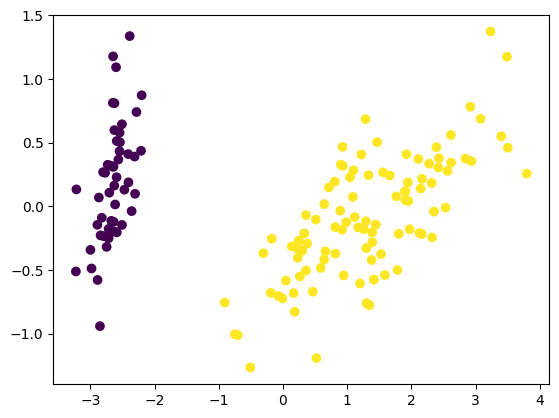

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=Y)


Training: 100% [-----------------------------------------------] Time:  0:00:58


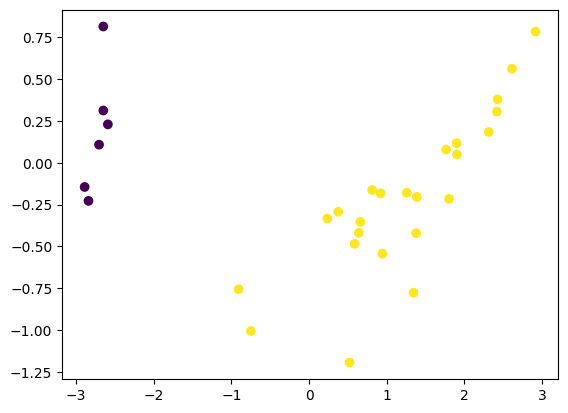

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, seed=123)
gbc = GradientBoostingClassifier(n_estimators=300, learning_rate=.05, min_samples_split=2, min_info_gain=1e-7, max_depth=2, debug=False)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

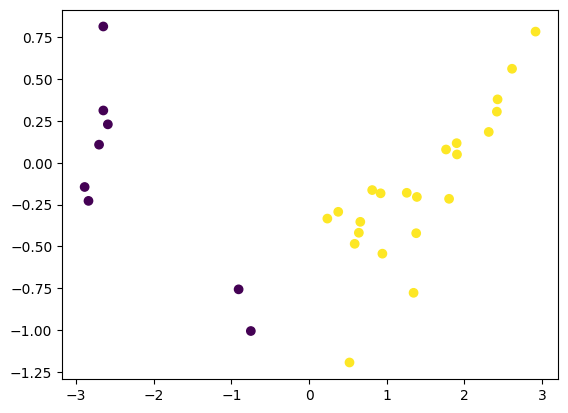

In [ ]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

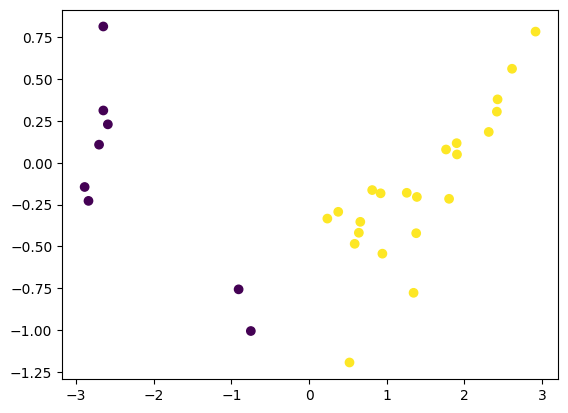

In [ ]:
dt = ClassificationTree(min_samples_split=4, min_impurity=1e-7, max_depth=4)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [ ]:
for tree in gbc.trees:
    tree.print_tree()

0:-0.7045317592446643? 
 T->[ 1.57894737 -1.57894737]
 F->[-2.72727273  2.72727273]
0:-0.7045317592446643? 
 T->[ 1.40394089 -1.40394089]
 F->[-1.98795181  1.98795181]
0:-0.7045317592446643? 
 T->[ 1.27799162 -1.27799162]
 F->[-1.6599497  1.6599497]
0:-0.7045317592446643? 
 T->[ 1.18150613 -1.18150613]
 F->[-1.45894802  1.45894802]
0:-0.7045317592446643? 
 T->[ 1.10442 -1.10442]
 F->[-1.31861273  1.31861273]
0:-0.7045317592446643? 
 T->[ 1.04093624 -1.04093624]
 F->[-1.21314552  1.21314552]
0:-0.7045317592446643? 
 T->[ 1. -1.]
 F->[-1.12999369  1.12999369]
0:-0.7045317592446643? 
 T->[ 1. -1.]
 F->[-1.06217959  1.06217959]
0:-0.7045317592446643? 
 T->[ 1. -1.]
 F->[-1.0054603  1.0054603]
0:-0.7045317592446643? 
 T->[ 1. -1.]
 F->[-1.  1.]
0:-0.7045317592446643? 
 T->[ 1. -1.]
 F->[-1.  1.]
0:-0.7045317592446643? 
 T->[ 1. -1.]
 F->[-1.  1.]
0:-0.7045317592446643? 
 T->[ 1. -1.]
 F->[-1.  1.]
0:-0.7045317592446643? 
 T->[ 1. -1.]
 F->[-1.  1.]
0:-0.7045317592446643? 
 T->[ 1. -1.]
 F->

Text(0, 0.5, 'X2')

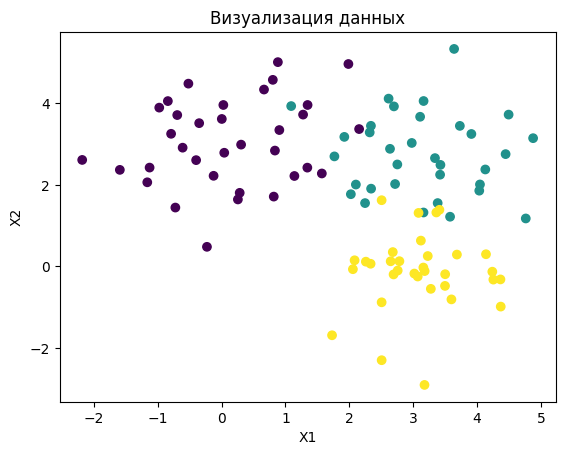

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=100, centers=[(0,3),(3,3),(3,0)],
                                      n_features=2, random_state=123,
                                      cluster_std=(0.9,0.9,0.9))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Визуализация данных')
plt.xlabel('X1')
plt.ylabel('X2')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, seed=123)

In [ ]:
depth = 4
dt = ClassificationTree(min_samples_split=10, min_impurity=1e-7, max_depth=depth)
dt.fit(X_train, y_train)

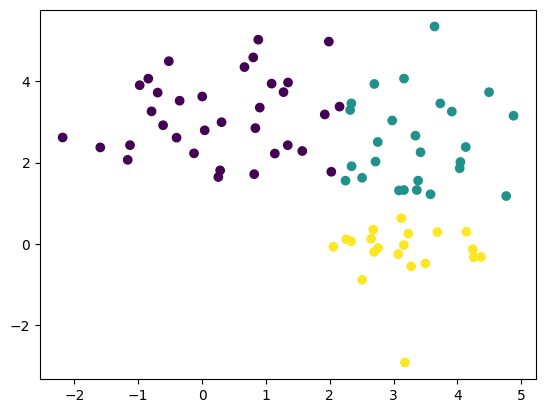

In [ ]:
y_pred = dt.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

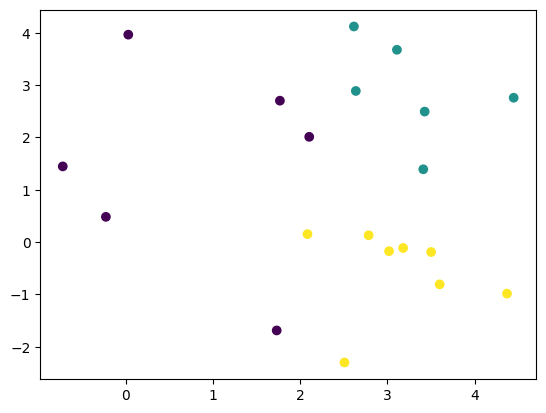

In [ ]:
y_pred = dt.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [ ]:
dt.print_tree()

0:2.02388887919481? 
 T->1:1.177458813302276? 
  T->1:1.772875609843274? 
    T->0:2.319206511540789? 
        T->1.0
        F->0.0
    F->1.0
  F->2.0
 F->0:1.0892096849618025? 
  T->0.0
  F->0.0


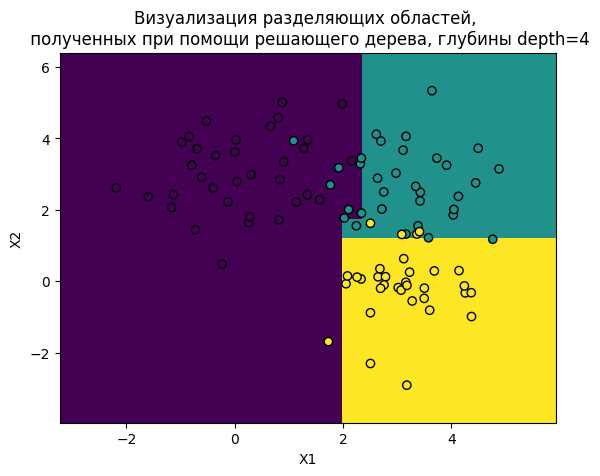

In [ ]:
X0 = np.linspace(X[:, 0].min()-1,X[:, 0].max()+1, X.shape[0])
X1 = np.linspace(X[:, 1].min()-1,X[:, 1].max()+1, X.shape[0])
X0_grid, X1_grid = np.meshgrid(X0, X1)

y_predict = np.array(dt.predict(np.c_[X0_grid.ravel(),X1_grid.ravel()])).reshape(X0_grid.shape)
plt.pcolormesh(X0_grid, X1_grid, y_predict)

plt.scatter(X[:, 0], X[:, 1], c=y,  edgecolors='black',linewidth=1)

plt.title('Визуализация разделяющих областей, \n полученных при помощи решающего дерева, глубины depth={}'.format(depth))
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [ ]:
n_samples = 100
X = np.sort(np.random.rand(n_samples))
y = np.exp(X ** 2)+np.random.normal(0.0, 0.1, X.shape[0])
X = np.expand_dims(X, axis=1)
y = np.expand_dims(y, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, seed=123)

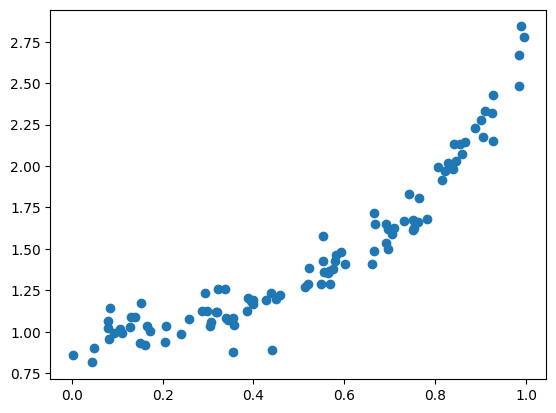

In [ ]:
plt.scatter(X, y)

In [ ]:
y_train

array([[1.01331135],
       [1.62791804],
       [2.02085148],
       [1.11630001],
       [1.7179265 ],
       [0.85881834],
       [0.95364294],
       [1.57684811],
       [1.97065455],
       [1.06170443],
       [1.23650902],
       [1.65053561],
       [1.66494692],
       [1.4070444 ],
       [1.12286449],
       [1.231411  ],
       [1.8080645 ],
       [1.18599358],
       [1.38082107],
       [1.62691485],
       [1.03844384],
       [2.14549745],
       [1.03654344],
       [1.25519495],
       [1.08564103],
       [2.17225947],
       [2.02797001],
       [0.99308913],
       [1.35439894],
       [1.18878083],
       [1.07586779],
       [2.2806604 ],
       [0.87801363],
       [1.58853451],
       [2.13400447],
       [2.0729865 ],
       [2.14888641],
       [2.66778059],
       [1.48899163],
       [1.08590892],
       [0.98564587],
       [2.22759741],
       [1.20248373],
       [1.47967682],
       [0.81421516],
       [1.67284946],
       [1.08772852],
       [1.993

In [ ]:
depth = 16
dt = RegressionTree(min_samples_split=10, min_impurity=1e-7, max_depth=depth)
dt.fit(X_train, y_train)

Text(0, 0.5, 'X2')

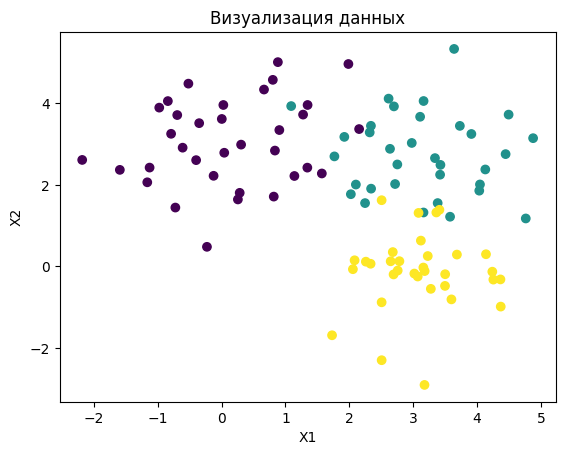

In [ ]:
X, y = make_blobs(n_samples=100, centers=[(0,3),(3,3),(3,0)],
                                      n_features=2, random_state=123,
                                      cluster_std=(0.9,0.9,0.9))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title('Визуализация данных')
plt.xlabel('X1')
plt.ylabel('X2')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, seed=123)

Training: 100% [-----------------------------------------------] Time:  0:00:12


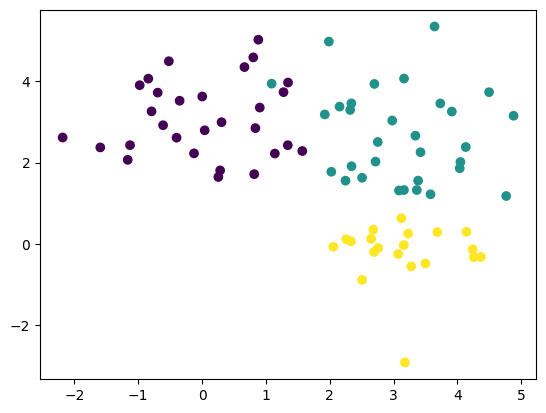

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=.05, min_samples_split=4, min_info_gain=1e-7, max_depth=2, debug=False)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

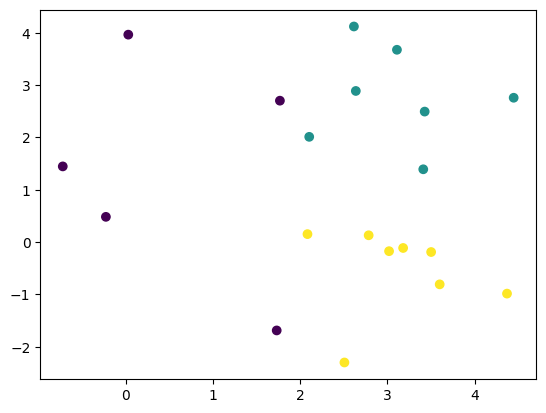

In [ ]:
y_pred = gbc.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

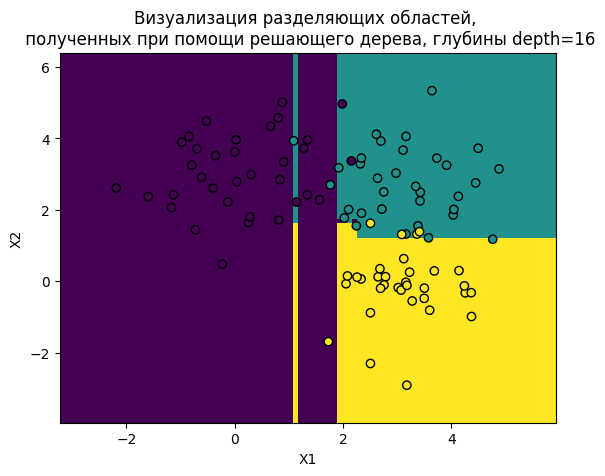

In [ ]:
X0 = np.linspace(X[:, 0].min()-1,X[:, 0].max()+1, X.shape[0])
X1 = np.linspace(X[:, 1].min()-1,X[:, 1].max()+1, X.shape[0])
X0_grid, X1_grid = np.meshgrid(X0, X1)

y_predict = np.array(gbc.predict(np.c_[X0_grid.ravel(),X1_grid.ravel()])).reshape(X0_grid.shape)
plt.pcolormesh(X0_grid, X1_grid, y_predict)

plt.scatter(X[:, 0], X[:, 1], c=y,  edgecolors='black',linewidth=1)

plt.title('Визуализация разделяющих областей, \n полученных при помощи решающего дерева, глубины depth={}'.format(depth))
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [ ]:
class Sigmoid():
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

In [ ]:
class LogisticLoss():
    def __init__(self):
        sigmoid = Sigmoid()
        self.log_func = sigmoid
        self.log_grad = sigmoid.gradient

    def loss(self, y, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        p = self.log_func(y_pred)
        return y * np.log(p) + (1 - y) * np.log(1 - p)

    # gradient w.r.t y_pred
    def gradient(self, y, y_pred):
        p = self.log_func(y_pred)
        return -(y - p)

    # w.r.t y_pred
    def hess(self, y, y_pred):
        p = self.log_func(y_pred)
        return p * (1 - p)


In [ ]:
class XGBoostRegressionTree(DecisionTree):
    """
    Regression tree for XGBoost
    - Reference -
    http://xgboost.readthedocs.io/en/latest/model.html
    """

    def _split(self, y):
        """ y contains y_true in left half of the middle column and
        y_pred in the right half. Split and return the two matrices """
        col = int(np.shape(y)[1]/2)
        y, y_pred = y[:, :col], y[:, col:]
        return y, y_pred

    def _gain(self, y, y_pred):
        nominator = np.power((y * self.loss.gradient(y, y_pred)).sum(), 2)
        denominator = self.loss.hess(y, y_pred).sum()
        return 0.5 * (nominator / denominator)

    def _gain_by_taylor(self, y, y1, y2):
        # Split
        y, y_pred = self._split(y)
        y1, y1_pred = self._split(y1)
        y2, y2_pred = self._split(y2)

        true_gain = self._gain(y1, y1_pred)
        false_gain = self._gain(y2, y2_pred)
        gain = self._gain(y, y_pred)
        return true_gain + false_gain - gain

    def _approximate_update(self, y):
        # y split into y, y_pred
        y, y_pred = self._split(y)
        # Newton's Method
        gradient = np.sum(y * self.loss.gradient(y, y_pred), axis=0)
        hessian = np.sum(self.loss.hess(y, y_pred), axis=0)
        update_approximation =  gradient / hessian

        return update_approximation

    def fit(self, X, y):
        self._impurity_calculation = self._gain_by_taylor
        self._leaf_value_calculation = self._approximate_update
        super(XGBoostRegressionTree, self).fit(X, y)

In [ ]:
class XGBoost(object):
    """The XGBoost classifier.

    Reference: http://xgboost.readthedocs.io/en/latest/model.html

    Parameters:
    -----------
    n_estimators: int
        The number of classification trees that are used.
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    min_samples_split: int
        The minimum number of samples needed to make a split when building a tree.
    min_impurity: float
        The minimum impurity required to split the tree further.
    max_depth: int
        The maximum depth of a tree.
    """
    def __init__(self, n_estimators=200, learning_rate=0.001, min_samples_split=2,
                 min_impurity=1e-7, max_depth=2):
        self.n_estimators = n_estimators            # Number of trees
        self.learning_rate = learning_rate          # Step size for weight update
        self.min_samples_split = min_samples_split  # The minimum n of sampels to justify split
        self.min_impurity = min_impurity              # Minimum variance reduction to continue
        self.max_depth = max_depth                  # Maximum depth for tree

        self.bar = progressbar.ProgressBar(widgets=bar_widgets)

        # Log loss for classification
        self.loss = LogisticLoss()

        # Initialize regression trees
        self.trees = []
        for _ in range(n_estimators):
            tree = XGBoostRegressionTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_impurity,
                    max_depth=self.max_depth,
                    loss=self.loss)

            self.trees.append(tree)

    def fit(self, X, y):
        y = to_categorical(y)

        y_pred = np.zeros(np.shape(y))
        for i in self.bar(range(self.n_estimators)):
            tree = self.trees[i]
            y_and_pred = np.concatenate((y, y_pred), axis=1)
            tree.fit(X, y_and_pred)
            update_pred = tree.predict(X)

            y_pred -= np.multiply(self.learning_rate, update_pred)

    def predict(self, X):
        y_pred = None
        # Make predictions
        for tree in self.trees:
            # Estimate gradient and update prediction
            update_pred = tree.predict(X)
            if y_pred is None:
                y_pred = np.zeros_like(update_pred)
            y_pred -= np.multiply(self.learning_rate, update_pred)

        # Turn into probability distribution (Softmax)
        y_pred = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)
        # Set label to the value that maximizes probability
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred

Training: 100% [-----------------------------------------------] Time:  0:00:15


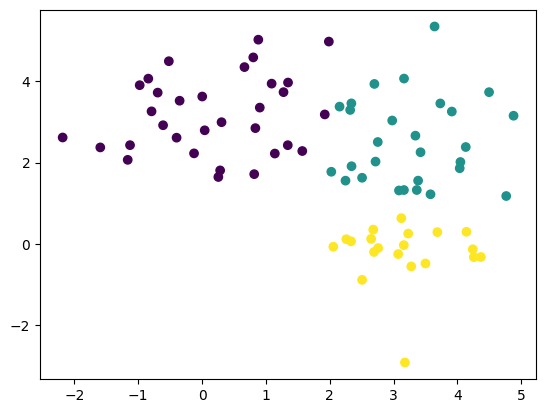

In [ ]:
xgb = XGBoost(n_estimators=150, learning_rate=.05, min_samples_split=4, min_impurity=1e-7, max_depth=2)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

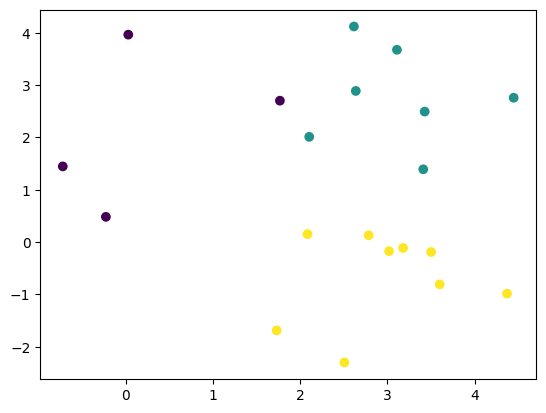

In [ ]:
y_pred = xgb.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

### German Credit Card

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv(r'German Credit Cards UCI.csv')
df.head()

,Customer ID,Checking Account Status,Loan Duration (Months),Credit History,Purpose,Loan Amount,Savings Account Balance,Present Employment Time (Years),Installment Rate in Percentage of Disposable Income,Personal Status and Gender,...,Property,Age (Years),Other Credits,Home Ownership,Number of Existing Credits at This Bank,Job Category,Number of Dependents,Telephone,Foreign Worker Status,Loan Status
0,1122334,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,...,real estate,67,none,own,2,skilled,1,yes,yes,fully paid
1,6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,...,real estate,22,none,own,1,skilled,1,none,yes,charged off
2,2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,fully paid
3,8740590,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,fully paid
4,3924540,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,...,unknown-none,53,none,for free,2,skilled,2,none,yes,charged off


In [ ]:
X = df.drop(columns=['Loan Status', 'Customer ID'])
Y = df['Loan Status']
X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = Y.apply(lambda x: 1 if x == 'fully paid' else 0).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, seed=123)

Training: 100% [-----------------------------------------------] Time:  0:03:18


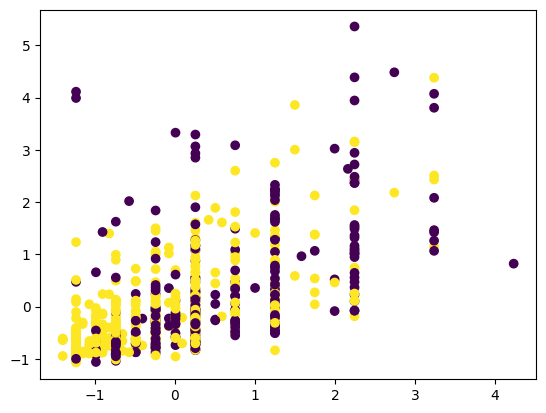

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=.05, min_samples_split=4, min_info_gain=1e-7, max_depth=2, debug=False)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

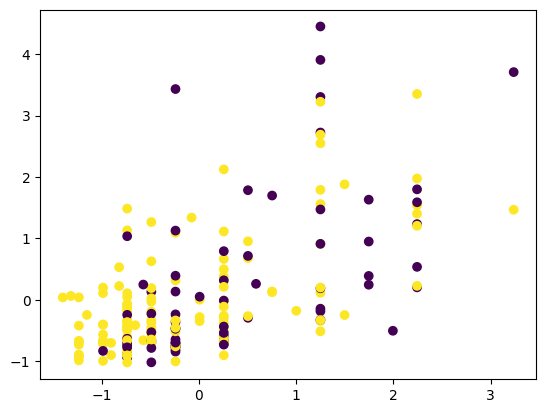

In [ ]:
y_pred = gbc.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

Accuracy: 0.7178217821782178
Precision: 0.8396946564885496
Recall: 0.7534246575342466
F1 score: 0.7942238267148014


Training: 100% [-----------------------------------------------] Time:  0:08:09


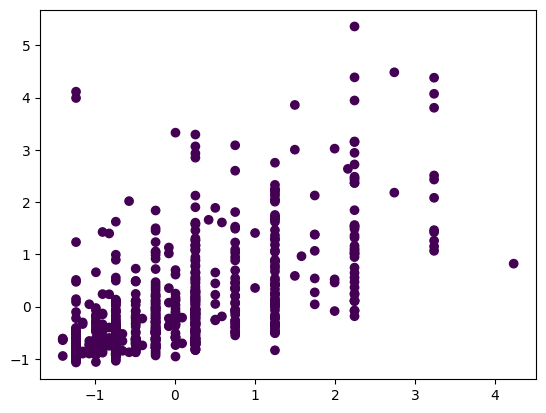

In [ ]:
xgb = XGBoost(n_estimators=150, learning_rate=.05, min_samples_split=4, min_impurity=1e-7, max_depth=2)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

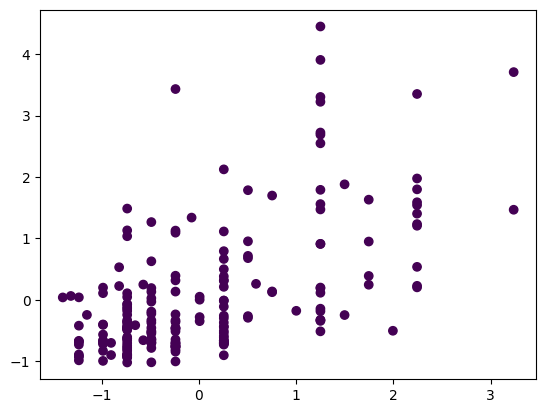

In [ ]:
y_pred = xgb.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

Accuracy: 0.7227722772277227
Precision: 0.7227722772277227
Recall: 1.0
F1 score: 0.8390804597701149


### Video games

In [ ]:
data = pd.read_csv('Video Games.csv', index_col='id')

In [ ]:
data = pd.get_dummies(data, drop_first=True)
Y = data['jp_sales'].values
X = data.drop(columns=['jp_sales']).values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, seed=123)

In [ ]:
gbc_regr = GradientBoostingRegressor(n_estimators=10, learning_rate=.1, min_samples_split=5, max_depth=5, debug=False)
gbc_regr.fit(X_train, y_train)
y_pred = gbc_regr.predict(X_train)

Training: 100% [-----------------------------------------------] Time:  0:08:20


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

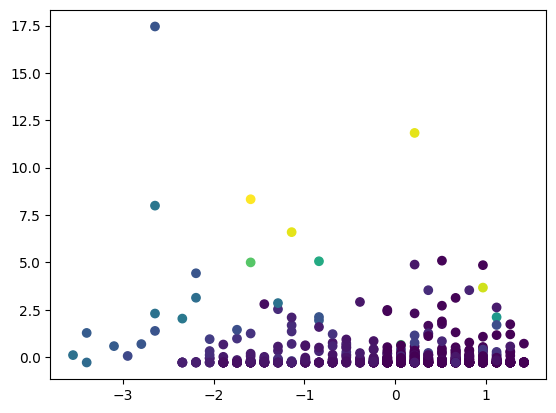

In [ ]:
y_pred = gbc_regr.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape)

MSE: 1.6951244436642663
MAE: 1.2151896179111703
MAPE: 1.0246944027741216


#### n?

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('insclass_train.csv')

In [ ]:
df.drop(df.columns[[6, 8, 14]], axis=1, inplace=True)
df.dropna(inplace=True)
df_sampled = df.sample(frac=0.2, random_state=1)
df.info()

In [ ]:
float64_cols = list(df.select_dtypes(include='float64'))
int64_cols = list(df.select_dtypes(include='int64'))
df_sampled[float64_cols] = df_sampled[float64_cols].astype('float32')
df_sampled[int64_cols] = df_sampled[int64_cols].astype('int16')

In [ ]:
!pip install category_encoders

import category_encoders as ce

In [ ]:
cat_cols = ['variable_1', 'variable_5', 'variable_20', 'variable_21', 'variable_22', 'variable_28']

In [ ]:
df_encoded = ce.TargetEncoder().fit_transform(X=df_sampled[cat_cols], y=df_sampled['target'])

In [ ]:
df_encoded.head()

In [ ]:
df_sampled[cat_cols] = df_encoded[cat_cols]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_sampled.drop(['target'], axis=1).to_numpy(), df_sampled['target'].to_numpy().reshape(df_sampled['target'].shape[0], 1), test_size=0.2)
X_train.shape, y_train.shape

((19008, 25), (19008, 1))

In [ ]:
xgb = XGBoost(n_estimators=150, learning_rate=.05, min_samples_split=4, min_impurity=1e-7, max_depth=2)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_train)

Training: 100% [------------------------------------------------] Time: 0:54:11


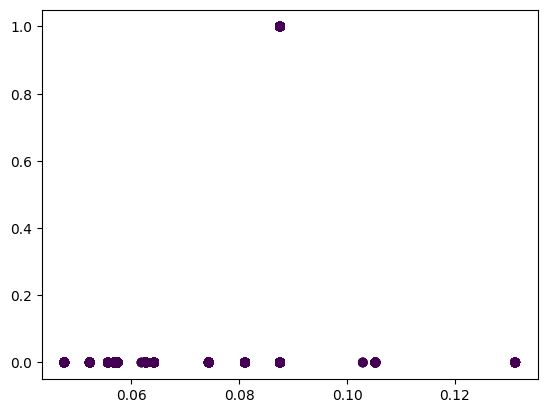

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_pred)

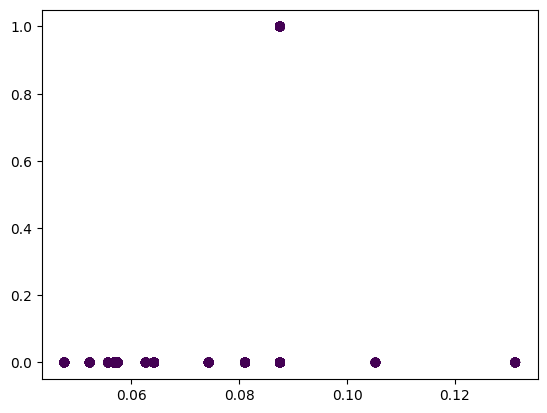

In [ ]:
y_pred = xgb.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [ ]:
(y_pred == y_test.T).sum()/(y_test.shape)[0]

0.9269781144781145

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=50, learning_rate=.1, min_samples_split=4, min_var_red=1e-7, max_depth=2, debug=False)
gbr.fit(X_train, y_train)

Training: 100% [------------------------------------------------] Time: 0:44:11


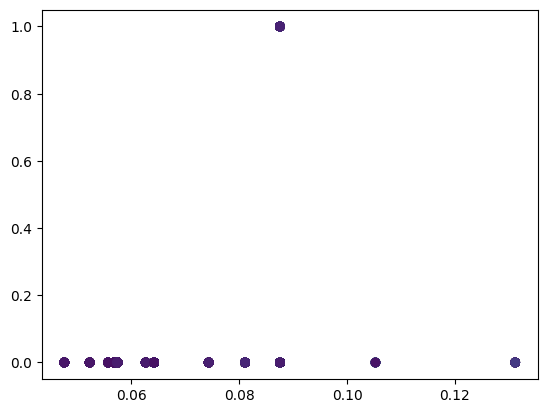

In [ ]:
y_pred = gbr.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)

In [ ]:
(y_pred == y_test).sum()/(y_test.shape)[0]

0.0

In [ ]:
y_pred

array([-0.03644061, -0.06178287, -0.03624194, ..., -0.02189279,
       -0.00877154, -0.01974539])